In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, learning_curve

# Load dataset
df = pd.read_csv("smart_traffic_management_dataset.csv")

In [32]:
# Convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%d-%m-%Y %H:%M")

# Extract useful time features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday  # 0 = Monday, 6 = Sunday

# Define congestion thresholds (70th percentile for traffic volume, 30th percentile for speed)
traffic_threshold = df['traffic_volume'].quantile(0.7)
speed_threshold = df['avg_vehicle_speed'].quantile(0.3)

# Apply rule-based congestion classification
df['congested'] = ((df['traffic_volume'] > traffic_threshold) & 
                   (df['avg_vehicle_speed'] < speed_threshold)).astype(int)

# Check how many congested instances we have
df['congested'].value_counts()


congested
0    1809
1     191
Name: count, dtype: int64

In [33]:
# Select features for clustering
clustering_features = df[['traffic_volume', 'avg_vehicle_speed', 'vehicle_count_cars', 
                          'vehicle_count_trucks', 'vehicle_count_bikes']]

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Map clusters to congestion labels
df['cluster_congested'] = df['cluster'].map({0: 0, 1: 1})  # Cluster 1 = Congested

# Define features and target variable
features = ['hour', 'weekday', 'traffic_volume', 'avg_vehicle_speed', 
            'vehicle_count_cars', 'vehicle_count_trucks', 'vehicle_count_bikes', 
            'temperature', 'humidity']
X = df[features]
y = df['cluster_congested']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Optimized Random Forest Model to prevent overfitting
rf_model_tuned = RandomForestClassifier(n_estimators=50, max_depth=5, max_leaf_nodes=20, random_state=42)
rf_model_tuned.fit(X_train, y_train)

# Predictions
y_pred_tuned = rf_model_tuned.predict(X_test)

# Evaluate Model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("Optimized Model Accuracy:", accuracy_tuned)
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))

# Perform Cross-Validation to ensure stability
cv_scores = cross_val_score(rf_model_tuned, X, y, cv=5, scoring='accuracy')
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
print(f"Cross-Validation Accuracy: {cv_mean:.4f} (+/- {cv_std:.4f})")

Optimized Model Accuracy: 0.9775
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       194
           1       0.97      0.99      0.98       206

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400

Cross-Validation Accuracy: 0.9735 (+/- 0.0066)


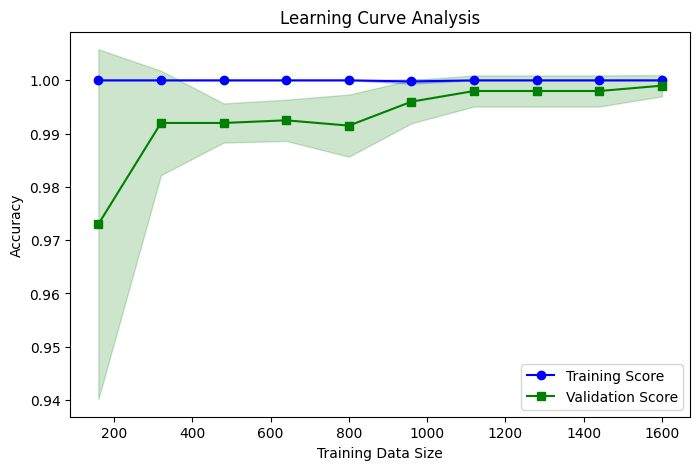

In [ ]:
# Learning curve analysis
train_sizes, train_scores, test_scores = learning_curve(
    rf_model_tuned, X, y, cv=5, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean and std of training/test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

plt.plot(train_sizes, test_mean, label="Validation Score", color="green", marker="s")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="green")

plt.xlabel("Training Data Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve Analysis")
plt.legend()
plt.show()


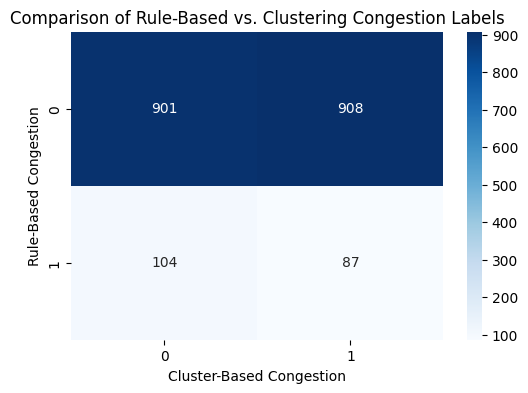

In [34]:
# Fixing the issue by ensuring integer values before plotting
comparison_table = df[['congested', 'cluster_congested']].value_counts().unstack().fillna(0).astype(int)

# Plot corrected heatmap
plt.figure(figsize=(6,4))
sns.heatmap(comparison_table, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Cluster-Based Congestion")
plt.ylabel("Rule-Based Congestion")
plt.title("Comparison of Rule-Based vs. Clustering Congestion Labels")
plt.show()


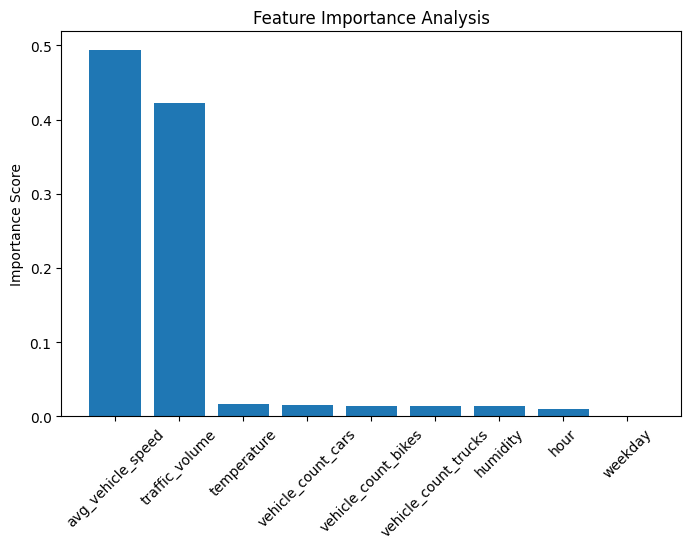

In [36]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.title("Feature Importance Analysis")
plt.bar(range(len(importances)), importances[sorted_indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=45)
plt.ylabel("Importance Score")
plt.show()
